In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [ ]:
sdir = '/content/drive/MyDrive/XrayKneeOsteoarthritis'
image_size = (224, 224)
batch_size = 32
k_folds = 5

In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
1  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
2  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
3  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
4  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      2
labels
0    3798
2    2545
4    1790
1    1749
3    1281
Name: count, dtype: int64


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)

print(train_df['labels'].value_counts())
print(test_df['labels'].value_counts())

labels
0    2659
2    1781
4    1253
1    1224
3     897
Name: count, dtype: int64
labels
0    1139
2     764
4     537
1     525
3     384
Name: count, dtype: int64


In [ ]:
datagen = ImageDataGenerator(
  rescale=1.0/255,
  horizontal_flip = True,
  )

valid_generator = ImageDataGenerator(
    rescale = 1./255
)

test_generator = ImageDataGenerator(
    rescale = 1./255
)

test_gen = test_generator.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=image_size,
    batch_size=batch_size, class_mode='categorical', shuffle = True
)

print("Preprocessing dataset selesai.")

Found 3349 validated image filenames belonging to 5 classes.
Preprocessing dataset selesai.


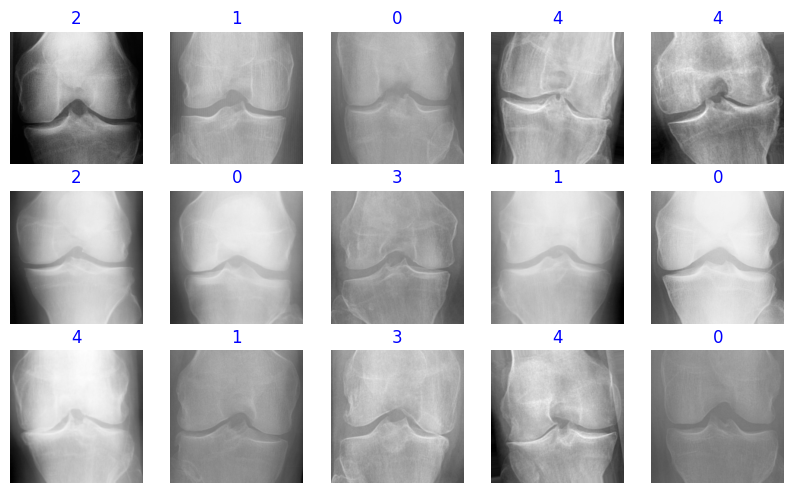

In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(10, 10))
    length=len(labels)
    if length<15:   #show maximum of 25 images
        r=length
    else:
        r=15
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

show_image_samples(test_gen)

In [ ]:
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

def create_model():
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze semua layer kecuali 4 terakhir
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    x = base_model.output

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

fold_accuracies = []
histories = []
fold = 1

for train_index, val_index in kf.split(train_df, train_df['labels']):
    print(f'\nTraining Fold {fold}...')

    fold_train_df = train_df.iloc[train_index].reset_index(drop = True)
    fold_valid_df = train_df.iloc[val_index].reset_index(drop = True)

    classes = np.unique(fold_train_df['labels'])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_train_df['labels'])
    class_weight_dict = dict(zip(classes, class_weights))
    print(f"Class weights (Fold {fold}):", class_weight_dict)

    train_gen = datagen.flow_from_dataframe(
        fold_train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_gen = valid_generator.flow_from_dataframe(
        fold_valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stopping, reduce_lr]
    )

    histories.append(history)

    scores = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold} - Loss: {scores[0]} - Accuracy: {scores[1]*100:.2f}%")

    fold_accuracies.append(scores[1] * 100)
    fold += 1

print('=================================')
print(f'Average accuracy over {k_folds} folds: {np.mean(fold_accuracies):.2f}% (+/- {np.std(fold_accuracies):.2f})')
print('=================================')



Training Fold 1...
Class weights (Fold 1): {'0': np.float64(0.5877762106252938), '1': np.float64(1.277017364657814), '2': np.float64(0.8773333333333333), '3': np.float64(1.7436541143654114), '4': np.float64(1.2464606181455633)}
Found 6251 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2576s 13s/step - accuracy: 0.3454 - loss: 1.5563 - val_accuracy: 0.4805 - val_loss: 1.3262 - learning_rate: 1.0000e-04
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 291ms/step - accuracy: 0.5058 - loss: 1.1421 - val_accuracy: 0.5381 - val_loss: 1.0908 - learning_rate: 1.0000e-04
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 83s 297ms/step - accuracy: 0.5722 - loss: 1.0056 - val_accuracy: 0.4837 - val_loss: 1.5510 - learning_rate: 1.0000e-04
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 56s 286ms/step - accuracy: 0.6078 - loss: 0.9463 - val_accuracy: 0.6302 - val_loss: 0.8914 - learning_rate: 1.0000e-04
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 291ms/step - accuracy: 0.6302 - loss: 0.8798 - val_accuracy: 0.6276 - val_loss: 0.8843 - learning_rate: 1.0000e-04
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 83s 295ms/step - accuracy: 0.6418 - loss: 0.8529 - val_accuracy: 0.4587 - val_loss: 1.2697 - learning_rate: 1.0000e-04
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 28

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 69s 319ms/step - accuracy: 0.3625 - loss: 1.5148 - val_accuracy: 0.4427 - val_loss: 1.2876 - learning_rate: 1.0000e-04
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - accuracy: 0.5113 - loss: 1.1139 - val_accuracy: 0.6033 - val_loss: 0.9292 - learning_rate: 1.0000e-04
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 85s 304ms/step - accuracy: 0.5779 - loss: 1.0114 - val_accuracy: 0.5694 - val_loss: 0.9936 - learning_rate: 1.0000e-04
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - accuracy: 0.6111 - loss: 0.9082 - val_accuracy: 0.6296 - val_loss: 0.8893 - learning_rate: 1.0000e-04
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 289ms/step - accuracy: 0.6324 - loss: 0.8919 - val_accuracy: 0.4472 - val_loss: 1.5629 - learning_rate: 1.0000e-04
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 83s 295ms/step - accuracy: 0.6541 - loss: 0.8319 - val_accuracy: 0.5861 - val_loss: 1.1663 - learning_rate: 1.0000e-04
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 56s 28

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 69s 313ms/step - accuracy: 0.3238 - loss: 1.6005 - val_accuracy: 0.4472 - val_loss: 1.5065 - learning_rate: 1.0000e-04
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 290ms/step - accuracy: 0.4744 - loss: 1.2293 - val_accuracy: 0.2905 - val_loss: 1.8093 - learning_rate: 1.0000e-04
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - accuracy: 0.5665 - loss: 1.0150 - val_accuracy: 0.4677 - val_loss: 1.2565 - learning_rate: 1.0000e-04
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 59s 298ms/step - accuracy: 0.6160 - loss: 0.9248 - val_accuracy: 0.6436 - val_loss: 0.8583 - learning_rate: 1.0000e-04
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 289ms/step - accuracy: 0.6419 - loss: 0.8617 - val_accuracy: 0.5387 - val_loss: 1.1881 - learning_rate: 1.0000e-04
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 56s 288ms/step - accuracy: 0.6514 - loss: 0.8256 - val_accuracy: 0.6635 - val_loss: 0.8058 - learning_rate: 1.0000e-04
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 59s 29

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 70s 315ms/step - accuracy: 0.3382 - loss: 1.6028 - val_accuracy: 0.2591 - val_loss: 1.6668 - learning_rate: 1.0000e-04
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 59s 299ms/step - accuracy: 0.5066 - loss: 1.1326 - val_accuracy: 0.4671 - val_loss: 1.5641 - learning_rate: 1.0000e-04
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 290ms/step - accuracy: 0.5804 - loss: 0.9880 - val_accuracy: 0.6481 - val_loss: 0.8494 - learning_rate: 1.0000e-04
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 56s 288ms/step - accuracy: 0.6210 - loss: 0.9041 - val_accuracy: 0.6481 - val_loss: 0.8520 - learning_rate: 1.0000e-04
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 59s 302ms/step - accuracy: 0.6631 - loss: 0.8206 - val_accuracy: 0.6225 - val_loss: 0.9345 - learning_rate: 1.0000e-04
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 293ms/step - accuracy: 0.6718 - loss: 0.7824 - val_accuracy: 0.6859 - val_loss: 0.7671 - learning_rate: 2.0000e-05
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 29

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 88s 407ms/step - accuracy: 0.3435 - loss: 1.5346 - val_accuracy: 0.4283 - val_loss: 1.4326 - learning_rate: 1.0000e-04
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - accuracy: 0.4970 - loss: 1.1456 - val_accuracy: 0.4353 - val_loss: 1.4181 - learning_rate: 1.0000e-04
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 289ms/step - accuracy: 0.5535 - loss: 1.0231 - val_accuracy: 0.5679 - val_loss: 1.0047 - learning_rate: 1.0000e-04
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 83s 294ms/step - accuracy: 0.6205 - loss: 0.9122 - val_accuracy: 0.5256 - val_loss: 1.2553 - learning_rate: 1.0000e-04
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 289ms/step - accuracy: 0.6311 - loss: 0.8611 - val_accuracy: 0.6293 - val_loss: 0.8715 - learning_rate: 1.0000e-04
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 56s 287ms/step - accuracy: 0.6637 - loss: 0.8099 - val_accuracy: 0.4155 - val_loss: 2.2321 - learning_rate: 1.0000e-04
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 28

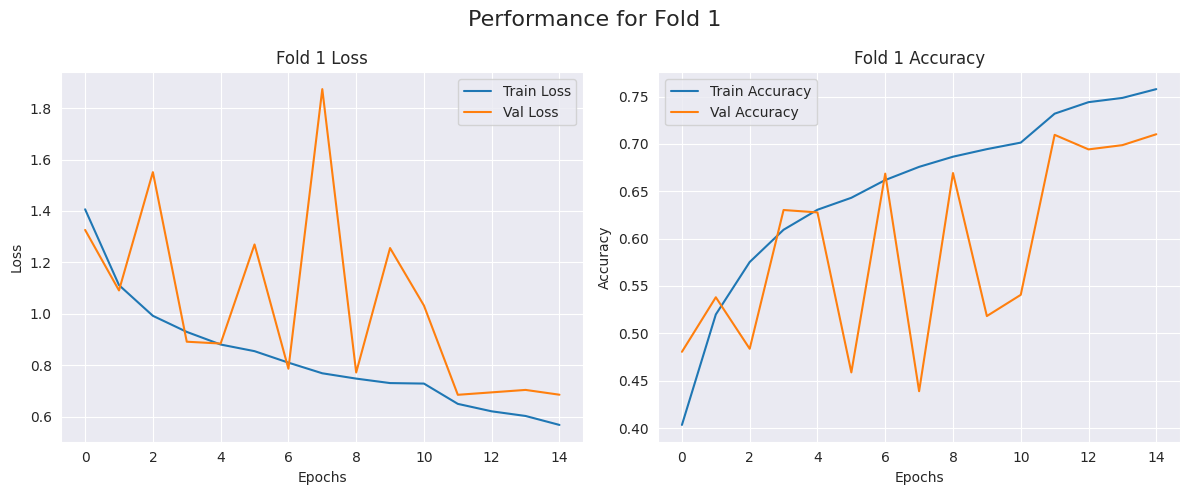

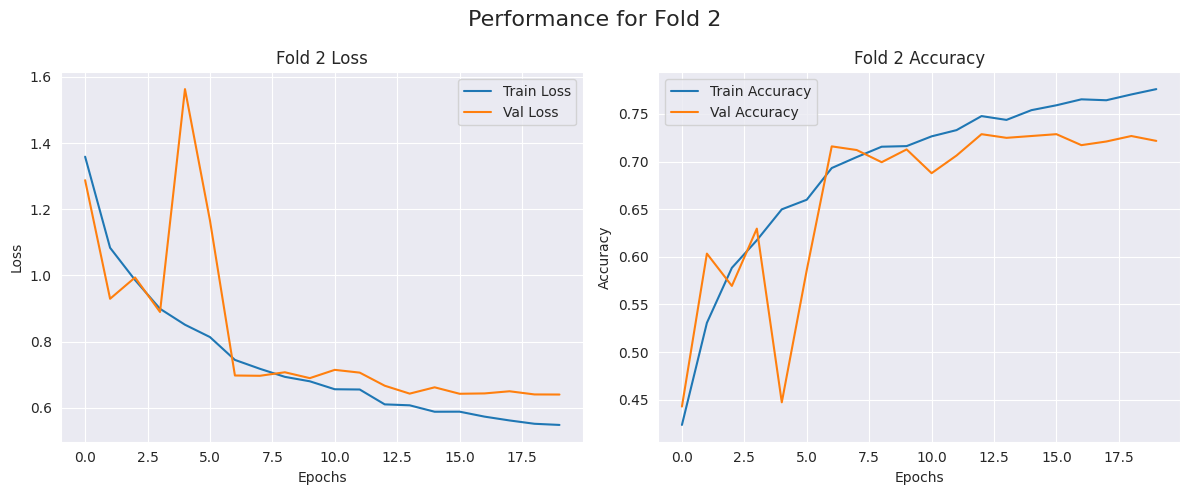

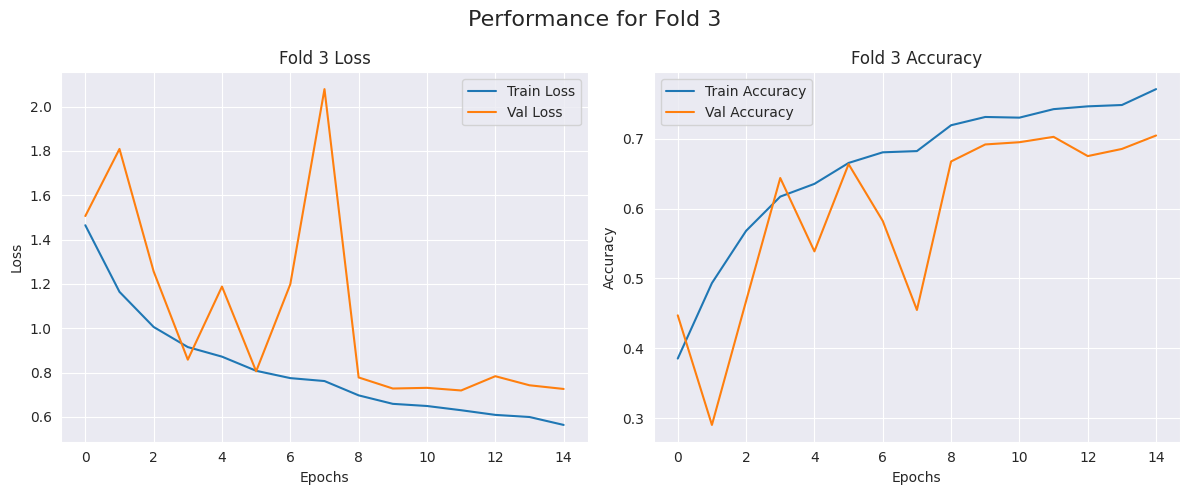

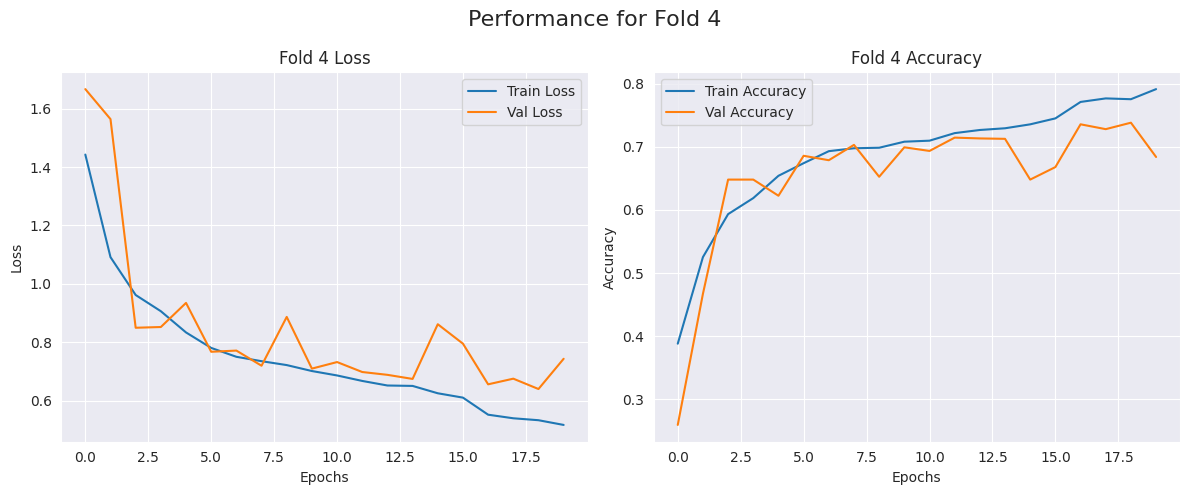

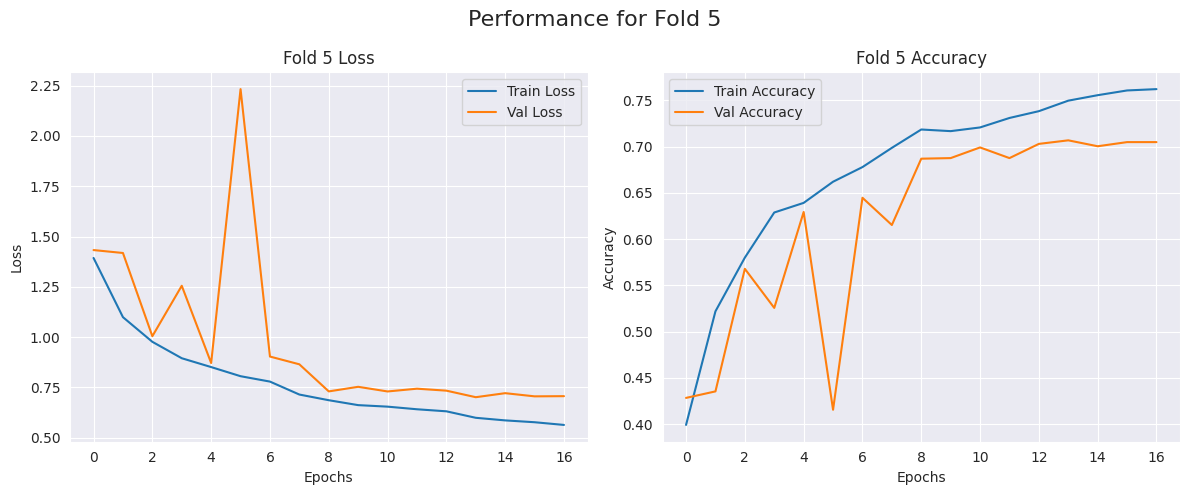

Semua plot selesai!


In [ ]:
for i, history in enumerate(histories, start=1):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(f'Performance for Fold {i}', fontsize=16)
    plt.tight_layout()
    plt.show()  # tampilkan plot fold i

print("Semua plot selesai!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

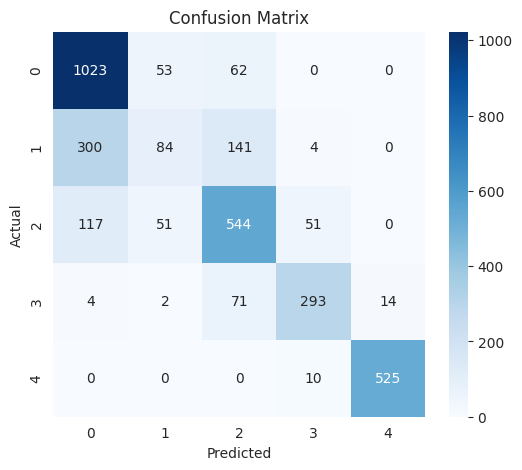

              precision    recall  f1-score   support

           0       0.71      0.90      0.79      1138
           1       0.44      0.16      0.23       529
           2       0.67      0.71      0.69       763
           3       0.82      0.76      0.79       384
           4       0.97      0.98      0.98       535

    accuracy                           0.74      3349
   macro avg       0.72      0.70      0.70      3349
weighted avg       0.71      0.74      0.71      3349



In [ ]:
y_true = []
y_pred = []
class_labels = list(test_gen.class_indices.keys())

for _ in range(len(test_gen)):
    x_batch, y_batch = next(test_gen)
    y_true.extend(np.argmax(y_batch, axis=1))  # Label asli
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))  # Prediksi model

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
model.save('/content/drive/MyDrive/my_model_70_30_32.h5')